In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import solve_banded

# Monte Carlo Approximation of Call Price, Delta, Gamma, and Theta Under Risk Neutral Measure

#### Price Calculation
The price of a call option is calculated based on the expected payoff under the risk-neutral measure, discounted at the risk-free rate. The stock price dynamics under the risk-neutral measure are given by the SDE:

$$
dS_t = r S_t \, dt + \sigma S_t \, dW_t
$$

where:

$S_t$ is the stock price at time $t$, <br>
$r$ is the risk-free interest rate, <br>
$\sigma$ is the volatility of the stock, <br>
$dW_t$ is the increment of Brownian motion.

The stock price at maturity $T$ can be simulated using the following equation derived from the above SDE:

$$
S_T = S_0 \exp\left(\left(r - \frac{1}{2} \sigma^2\right) T + \sigma \sqrt{T} Z\right)
$$
where $Z$ is a standard normal random variable.

The option price is then the expected value of the payoff, discounted at the risk-free rate:

$$
C_0 = e^{-rT} \mathbb{E}[\max(S_T - K, 0)]
$$

#### Greeks Calculation 

Delta is approximated using:

$$
\Delta \approx \frac{C(S_0 + \epsilon) - C(S_0 - \epsilon)}{2\epsilon}
$$
where $C(S_0)$ is the option price when the initial stock price is $S_0$ and $\epsilon$ is a small perturbation in the stock price.


Gamma is calculated using:

$$
\Gamma \approx \frac{C(S_0 + \epsilon) - 2C(S_0) + C(S_0 - \epsilon)}{\epsilon^2}
$$

Theta is generally negative for long positions as time decay erodes the value of the option. It is estimated using:

$$
\Theta \approx \frac{C(T + \Delta T) - C(T)}{\Delta T}
$$
where $\Delta T$ is a small increment in time.

#### Simulation Procedure
To implement the Monte Carlo simulation: <br>

Generate $N$ random samples from the standard normal distribution for $Z$. <br>
Compute $S_T$ for each sample using the stock price formula.<br>
Calculate the payoff for each simulated path and average them.<br>
Discount the average payoff at the risk-free rate to get the option price.<br>
Estimate the Greeks using the perturbation methods described.



In [2]:
S0 = 100
K = 100
T = 1
r = 0.05
sigma = 0.2
epsilon = S0 * 0.01
delta_T = 0.01
N = 1000000
N_values = np.linspace(1, 1000, 10, dtype= int).tolist()
M_values = np.linspace(100, 100000, 10, dtype= int).tolist()

In [3]:
def monte_carlo_and_greeks(S0, K, T, r, sigma, N, delta_T):
    np.random.seed(0)
    epsilon = 10
    Z = np.random.standard_normal(N)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoffs = np.maximum(ST - K, 0)
    C0 = np.exp(-r * T) * np.mean(payoffs)

    S_up = S0 + epsilon
    S_down = S0 - epsilon
    ST_up = S_up * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    ST_down = S_down * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoffs_up = np.maximum(ST_up - K, 0)
    payoffs_down = np.maximum(ST_down - K, 0)
    C_up = np.exp(-r * T) * np.mean(payoffs_up)
    C_down = np.exp(-r * T) * np.mean(payoffs_down)
    Delta = (C_up - C_down) / (2 * epsilon)
    Gamma = (C_up - 2 * C0 + C_down) / (epsilon ** 2)

    ST_T = S0 * np.exp((r - 0.5 * sigma**2) * (T - delta_T) + sigma * np.sqrt(T - delta_T) * Z)
    payoffs_T = np.maximum(ST_T - K, 0)
    C_T = np.exp(-r * (T - delta_T)) * np.mean(payoffs_T)
    Theta = (C_T - C0) / (delta_T)

    return C0, Delta, Gamma, Theta

price, delta, gamma, theta = monte_carlo_and_greeks(S0, K, T, r, sigma, 1000000, delta_T)
print(f"Price: {price}, Delta: {delta}, Gamma: {gamma}, Theta: {theta}")


Price: 10.469933998633085, Delta: 0.6295440666786519, Gamma: 0.018502304427902752, Theta: -6.43598230904594


## Plotting Monte Carlo Outputs with Different Simulation Numbers 

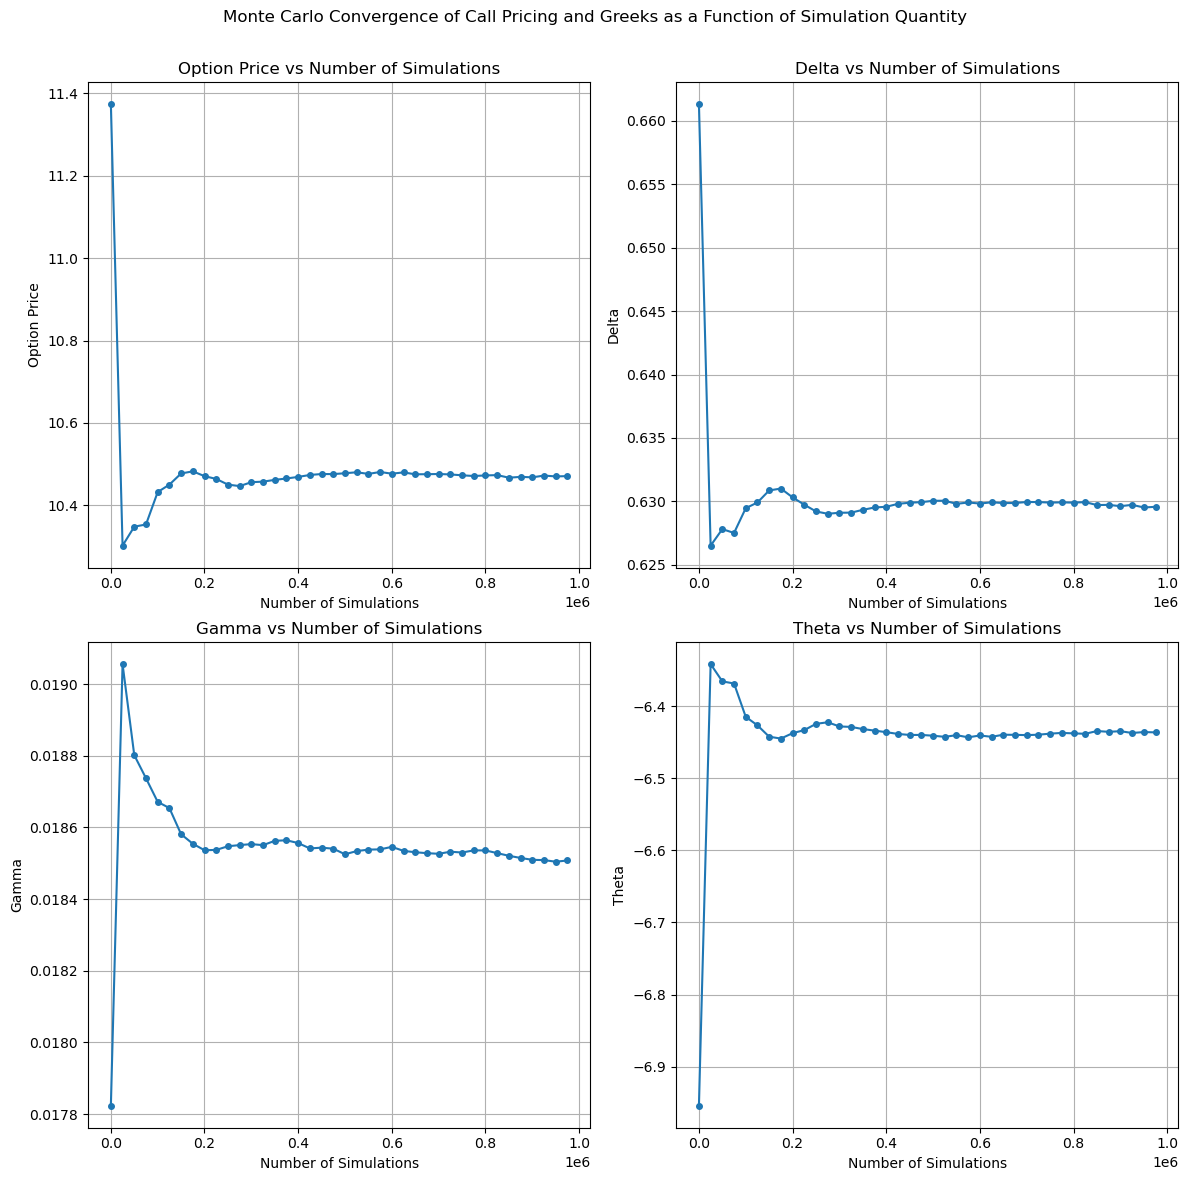

In [4]:
simulation_sizes = np.arange(100, 1000000, 25000).tolist()

results = []
for N in simulation_sizes:
    price, delta, gamma, theta = monte_carlo_and_greeks(S0, K, T, r, sigma, N, delta_T)
    results.append((N, price, delta, gamma, theta))

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
metrics = ['Option Price', 'Delta', 'Gamma', 'Theta']
for i, metric in enumerate(metrics):
    row, col = i // 2, i % 2
    values = [result[i + 1] for result in results]
    axs[row, col].plot(simulation_sizes, values, 'o-', markersize=4)
    axs[row, col].set_title(f'{metric} vs Number of Simulations')
    axs[row, col].set_xlabel('Number of Simulations')
    axs[row, col].set_ylabel(metric)
    axs[row, col].grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle("Monte Carlo Convergence of Call Pricing and Greeks as a Function of Simulation Quantity")
plt.show()

# Euler-Maruyama Approximation of Call Price, Delta, Gamma, and Theta Under Risk Neutral Measure

#### Euler Discretization
To simulate paths of the stock price over a time interval $[0, T]$, we discretize the interval into $N$ steps of size $\Delta t = \frac{T}{N}$. The Euler scheme approximates the stock price path at each step $k$ by:

$$
S_{t+\Delta t} = S_t + r S_t \Delta t + \sigma S_t \sqrt{\Delta t} Z_t,
$$

where $Z_t$ is a standard normal random variable.

#### Price Estimation
We simulate $M$ independent paths of the stock price using the Euler scheme. The payoff of a European call option at maturity is $max(S_T - K, 0)$, where $K$ is the strike price. The estimated option price is the average of discounted payoffs:

$$
C = e^{-rT} \frac{1}{M} \sum_{i=1}^M max(S_T^{(i)} - K, 0).
$$

#### Greeks Calculation

**Delta and Gamma:** These are estimated using finite difference methods. We simulate additional paths for $S_0 + \epsilon$ and $S_0 - \epsilon$ to calculate:

$$
\Delta \approx \frac{C(S_0 + \epsilon) - C(S_0 - \epsilon)}{2 \epsilon}, 
$$

$$
\Gamma \approx \frac{C(S_0 + \epsilon) - 2C(S_0) + C(S_0 - \epsilon)}{\epsilon^2}.
$$

**Theta:** We approximate Theta by simulating the option price with a slightly shorter maturity, $T - \delta$, and calculate:

$$
\Theta \approx \frac{C(T) - C(T - \delta)}{\delta}.
$$


In [5]:
def euler(S0, K, T, r, sigma, N, M):
    np.random.seed(0)
    dt = T / N
    discount_factor = np.exp(-r * T)
    epsilon = 10
    paths = np.zeros((M, 3), dtype=np.float64)
    paths[:, 0] = S0
    paths[:, 1] = S0 + epsilon
    paths[:, 2] = S0 - epsilon

    for _ in range(N):
        Z = np.random.standard_normal((M, 3))
        paths += r * paths * dt + sigma * paths * np.sqrt(dt) * Z

    payoffs = np.maximum(paths - K, 0)
    C = np.mean(payoffs[:, 0]) * discount_factor
    C_up = np.mean(payoffs[:, 1]) * discount_factor
    C_down = np.mean(payoffs[:, 2]) * discount_factor

    delta = (C_up - C_down) / (2 * epsilon)
    gamma = (C_up - 2 * C + C_down) / (epsilon ** 2)
    delta_t = dt
    T_short = T - delta_t
    dt_short = T_short / N
    paths_short = np.full(M, S0, dtype=np.float64)

    for _ in range(N):
        Z = np.random.standard_normal(M)
        paths_short += r * paths_short * dt_short + sigma * paths_short * np.sqrt(dt_short) * Z

    payoffs_short = np.maximum(paths_short - K, 0)
    C_short = np.mean(payoffs_short) * np.exp(-r * T_short)
    
    theta = (C-C_short) / (delta_t)

    return C, delta, gamma, theta

M = 100000
N= 500
eprice, edelta, egamma, etheta = euler(S0, K, T, r, sigma, N, M)
print("Price at inception:", eprice)
print("Delta at inception:", edelta)
print("Gamma at inception:", egamma)
print("Theta at inception:", etheta)

Price at inception: 10.409130943592352
Delta at inception: 0.6324228807634891
Gamma at inception: 0.02018416687497596
Theta at inception: -18.195532665180814


## Plotting Euler Method Outputs with Different Simulation Numbers 

In [6]:
def analytical_call(S0, sigma, T, K, r):
    N = norm.cdf
    dplus = (1 / sigma * np.sqrt(T)) * (np.log(S0 / K) + (r + (sigma ** 2 / 2)) * (T))
    dminus = dplus - sigma * np.sqrt(T)
    
    price = N(dplus) * S0 - N(dminus) * K * np.exp(-r * (T))
    
    delta = N(dplus)
    
    gamma = norm.pdf(dplus, 0, 1)/(S0*sigma*np.sqrt(T))
    
    theta = (-S0 * norm.pdf(dplus, 0, 1) * sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(dminus, 0, 1))
    
    return price, delta, gamma, theta
analytical_values = analytical_call(S0, sigma, T, K, r)

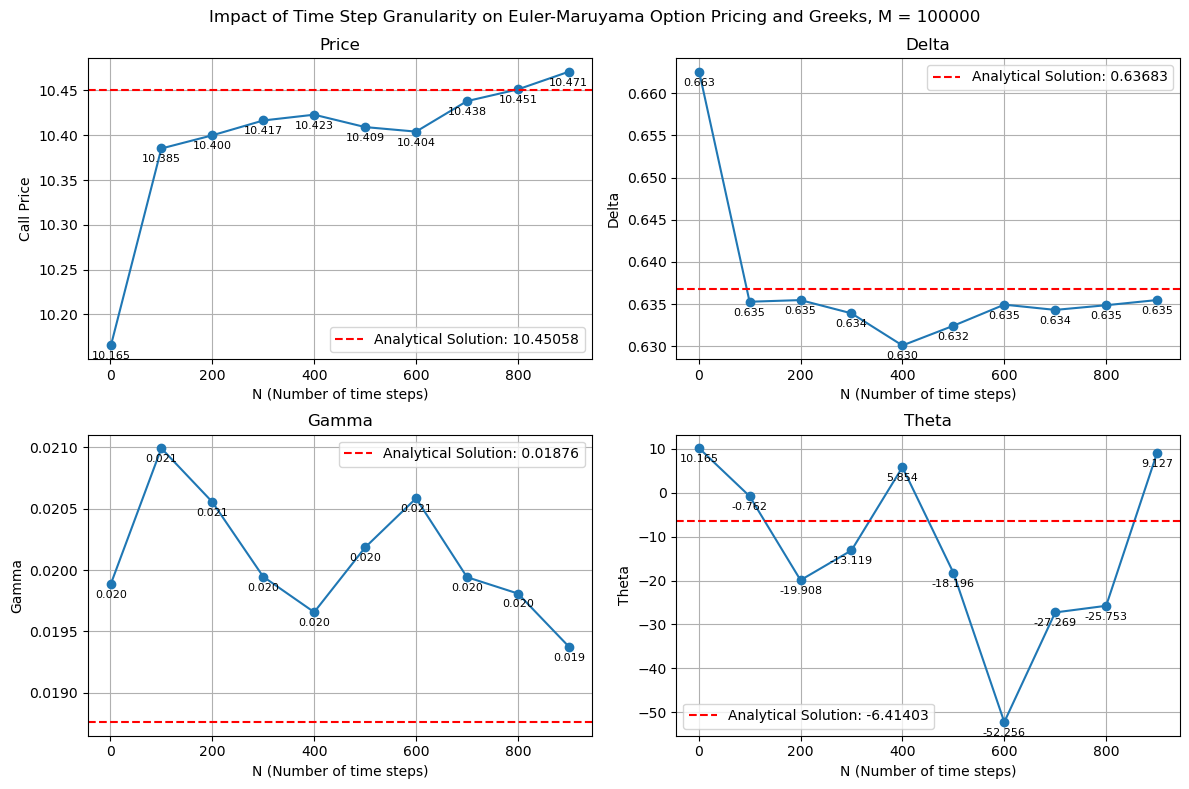

In [7]:
N_values = np.linspace(1, 900, 10, dtype= int).tolist()
M = 100000
results = []
for N in N_values:
    results.append(euler(S0, K, T, r, sigma, N, M))
prices, deltas, gammas, thetas = zip(*results)

plt.figure(figsize=(12, 8))
titles = ['Price', 'Delta', 'Gamma', 'Theta']
data = [prices, deltas, gammas, thetas]
y_labels = ['Call Price', 'Delta', 'Gamma', 'Theta']

for i, (title, dataset, y_label, h_line) in enumerate(zip(titles, data, y_labels, analytical_values), start=1):
    ax = plt.subplot(2, 2, i)
    ax.plot(N_values, dataset, marker='o')
    ax.set_title(title)
    ax.set_xlabel('N (Number of time steps)')
    ax.set_ylabel(y_label)
    ax.axhline(y=h_line, color='r', linestyle='--', label=f'Analytical Solution: {h_line:.5f}')
    ax.legend()
    ax.grid(True)
    for x, y in zip(N_values, dataset):
        ax.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,-10), ha='center', fontsize = 8)


plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle(f"Impact of Time Step Granularity on Euler-Maruyama Option Pricing and Greeks, M = {M}")

plt.show()


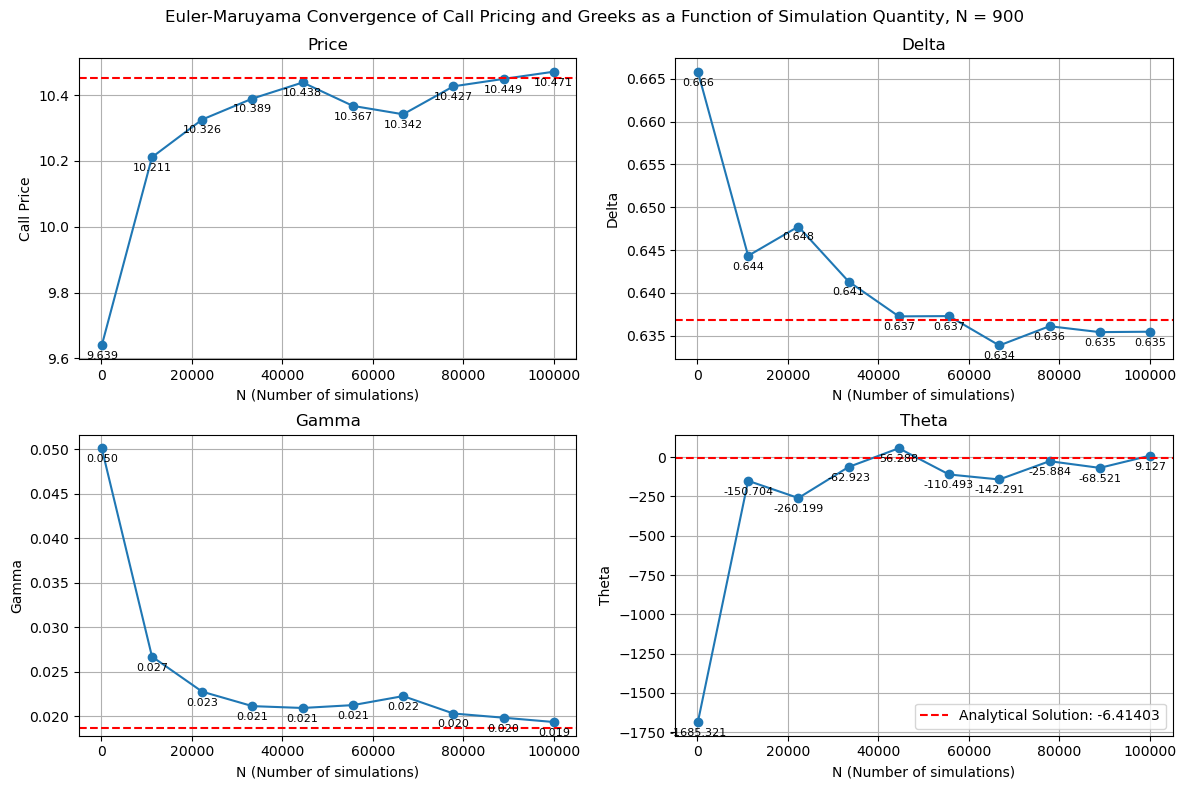

In [8]:
results = []
for M in M_values:
    results.append(euler(S0, K, T, r, sigma, N, M))
prices, deltas, gammas, thetas = zip(*results)

plt.figure(figsize=(12, 8))
titles = ['Price', 'Delta', 'Gamma', 'Theta']
data = [prices, deltas, gammas, thetas]
y_labels = ['Call Price', 'Delta', 'Gamma', 'Theta']

for i, (title, dataset, y_label, h_line) in enumerate(zip(titles, data, y_labels, analytical_values), start=1):
    ax = plt.subplot(2, 2, i)
    ax.plot(M_values, dataset, marker='o')
    ax.set_title(title)
    ax.set_xlabel('N (Number of simulations)')
    ax.set_ylabel(y_label)
    ax.axhline(y=h_line, color='r', linestyle='--', label=f'Analytical Solution: {h_line:.5f}')
    ax.grid(True)
    
    for x, y in zip(M_values, dataset):
        ax.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,-10), ha='center', fontsize = 8)
plt.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle(f"Euler-Maruyama Convergence of Call Pricing and Greeks as a Function of Simulation Quantity, N = {N}")
plt.show()


# Milstein Approximation of Call Price, Delta, Gamma, and Theta Under Risk Neutral Measure

#### Model Framework
The underlying asset's price process $S_t$ under the risk-neutral measure follows the stochastic differential equation:

$$
dS_t = r S_t dt + \sigma S_t dW_t,
$$

#### Milstein Discretization
The Milstein scheme provides a second-order convergence method for SDEs by incorporating additional correction terms involving the second derivative with respect to the driving Brownian motion. For the given SDE, the Milstein update formula is:

$$
S_{t+\Delta t} = S_t + r S_t \Delta t + \sigma S_t \sqrt{\Delta t} Z_t + \frac{1}{2} \sigma^2 S_t (\sqrt{\Delta t} Z_t)^2,
$$

where  $Z_t$ is a standard normal random variable.


#### Price Estimation
Using Monte Carlo simulation, $M$ paths of the underlying asset are simulated over $N$ time steps using the Milstein scheme. The option price is estimated as the mean of the discounted payoffs:

$$
C = e^{-rT} \frac{1}{M} \sum_{i=1}^M max(S_T^{(i)} - K, 0).
$$

#### Greeks Estimation

Delta and Gamma are calculated using finite differences by perturbing the initial stock price $S_0$:
$$
\Delta \approx \frac{C(S_0 + \epsilon) - C(S_0 - \epsilon)}{2 \epsilon}, \quad
\Gamma \approx \frac{C(S_0 + \epsilon) - 2C(S_0) + C(S_0 - \epsilon)}{\epsilon^2}
$$

Theta is estimated by reducing the time to maturity by a small amount $\delta$ and recalculating the option price:
$$
\Theta \approx \frac{C(T) - C(T - \delta)}{\delta}.
$$

In [9]:
def milstein(S0, K, T, r, sigma, N, M):
    np.random.seed(0)
    dt = T / N
    discount_factor = np.exp(-r * T)
    epsilon = 10
    paths = np.zeros((M, 3))  
    paths[:, 0] = S0
    paths[:, 1] = S0 + epsilon
    paths[:, 2] = S0 - epsilon

    for _ in range(N):
        dW = np.random.normal(0, np.sqrt(dt), (M, 3))
        paths += r * paths * dt + sigma * paths * dW + 0.5 * sigma**2 * paths * (dW**2 - dt)

    payoffs = np.maximum(paths - K, 0)
    price = np.mean(payoffs, axis=0) * discount_factor

    delta = (price[1] - price[2]) / (2 * epsilon)
    gamma = (price[1] - 2 * price[0] + price[2]) / (epsilon**2)
    
    paths_theta = S0 * np.ones(M)
    for _ in range(N-1):  
        dW = np.random.normal(0, np.sqrt(dt), M)
        paths_theta += r * paths_theta * dt + sigma * paths_theta * dW + 0.5 * sigma**2 * paths_theta * (dW**2 - dt)
    payoffs_theta = np.maximum(paths_theta - K, 0)
    price_theta = np.mean(payoffs_theta) * np.exp(-r * (T - dt))

    theta = (price[0]-price_theta) / (dt)

    return price[0], delta, gamma, theta
milstein(S0, K, T, r, sigma, 600, 100000)

(10.402824816954501,
 0.6348657623396277,
 0.020601797048303096,
 -49.63234823950984)

## Plotting Milstein Method Outputs with Different Time Steps

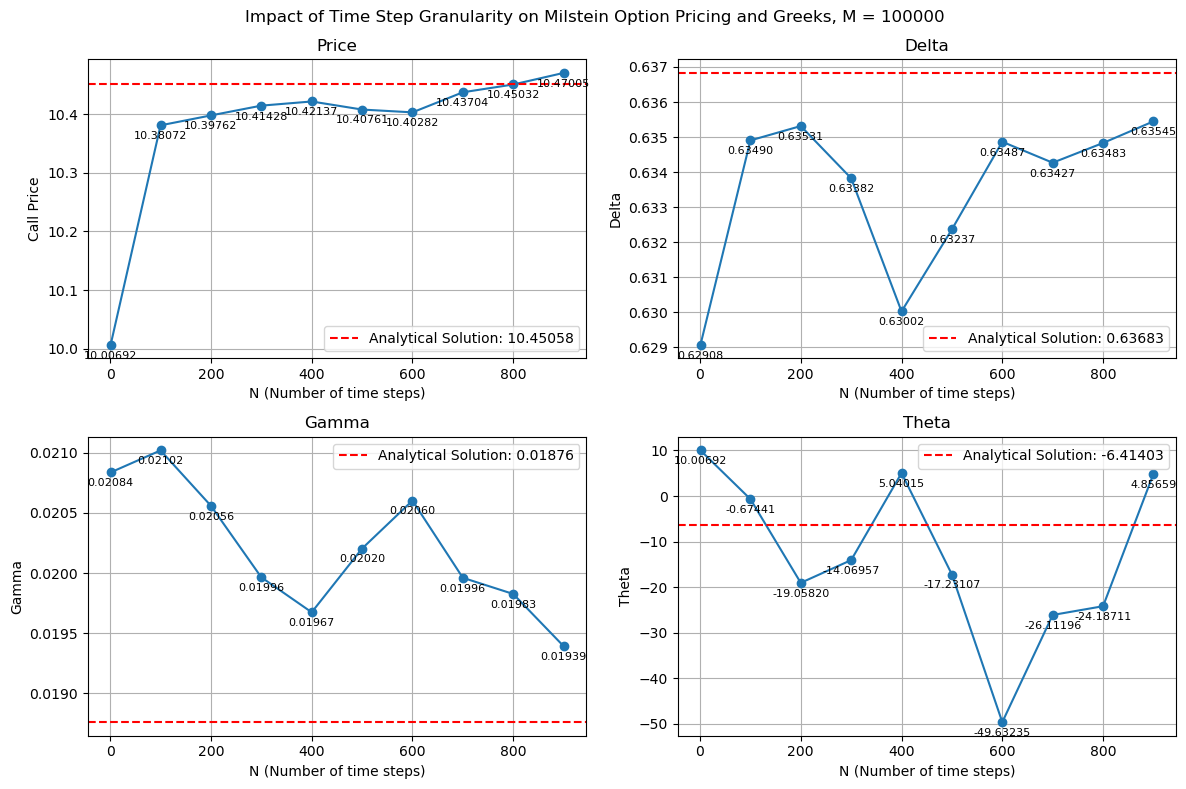

In [10]:
results = []
for N in N_values:
    results.append(milstein(S0, K, T, r, sigma, N, M))
prices, deltas, gammas, thetas = zip(*results)

# Plotting
plt.figure(figsize=(12, 8))
titles = ['Price', 'Delta', 'Gamma', 'Theta']
data = [prices, deltas, gammas, thetas]
y_labels = ['Call Price', 'Delta', 'Gamma', 'Theta']

for i, (title, dataset, y_label, h_line) in enumerate(zip(titles, data, y_labels, analytical_values), start=1):
    ax = plt.subplot(2, 2, i)
    ax.plot(N_values, dataset, marker='o')
    ax.set_title(title)
    ax.set_xlabel('N (Number of time steps)')
    ax.set_ylabel(y_label)
    ax.axhline(y=h_line, color='r', linestyle='--', label=f'Analytical Solution: {h_line:.5f}')
    ax.grid(True)
    ax.legend()
    # Annotating data points
    for x, y in zip(N_values, dataset):
        ax.annotate(f'{y:.5f}', (x, y), textcoords="offset points", xytext=(0,-10), ha='center', fontsize = 8)
plt.suptitle(f"Impact of Time Step Granularity on Milstein Option Pricing and Greeks, M = {M}")
plt.tight_layout()
plt.show()


##  Plotting Milstein Method Outputs with Different Simulation Numbers

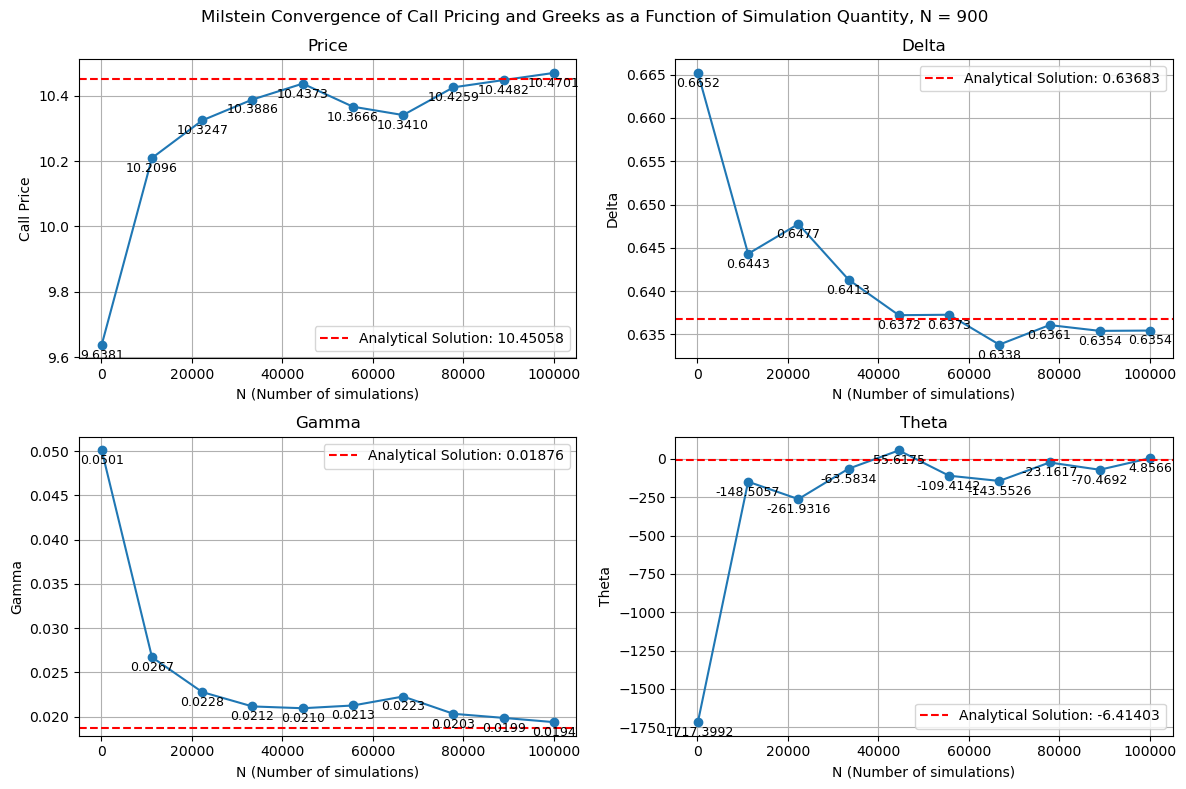

In [11]:
results = []
for M in M_values:
    results.append(milstein(S0, K, T, r, sigma, N, M))
prices, deltas, gammas, thetas = zip(*results)

# Plotting
plt.figure(figsize=(12, 8))
titles = ['Price', 'Delta', 'Gamma', 'Theta']
data = [prices, deltas, gammas, thetas]
y_labels = ['Call Price', 'Delta', 'Gamma', 'Theta']

for i, (title, dataset, y_label, h_line) in enumerate(zip(titles, data, y_labels, analytical_values), start=1):
    ax = plt.subplot(2, 2, i)
    ax.plot(M_values, dataset, marker='o')
    ax.set_title(title)
    ax.set_xlabel('N (Number of simulations)')
    ax.set_ylabel(y_label)
    ax.axhline(y=h_line, color='r', linestyle='--', label=f'Analytical Solution: {h_line:.5f}')
    ax.legend()
    ax.grid(True)
    # Annotating data points
    for x, y in zip(M_values, dataset):
        ax.annotate(f'{y:.4f}', (x, y), textcoords="offset points", xytext=(0,-10), ha='center', fontsize = 9)
plt.suptitle(f"Milstein Convergence of Call Pricing and Greeks as a Function of Simulation Quantity, N = {N}")
plt.tight_layout()
plt.show()


# Comparing Performance

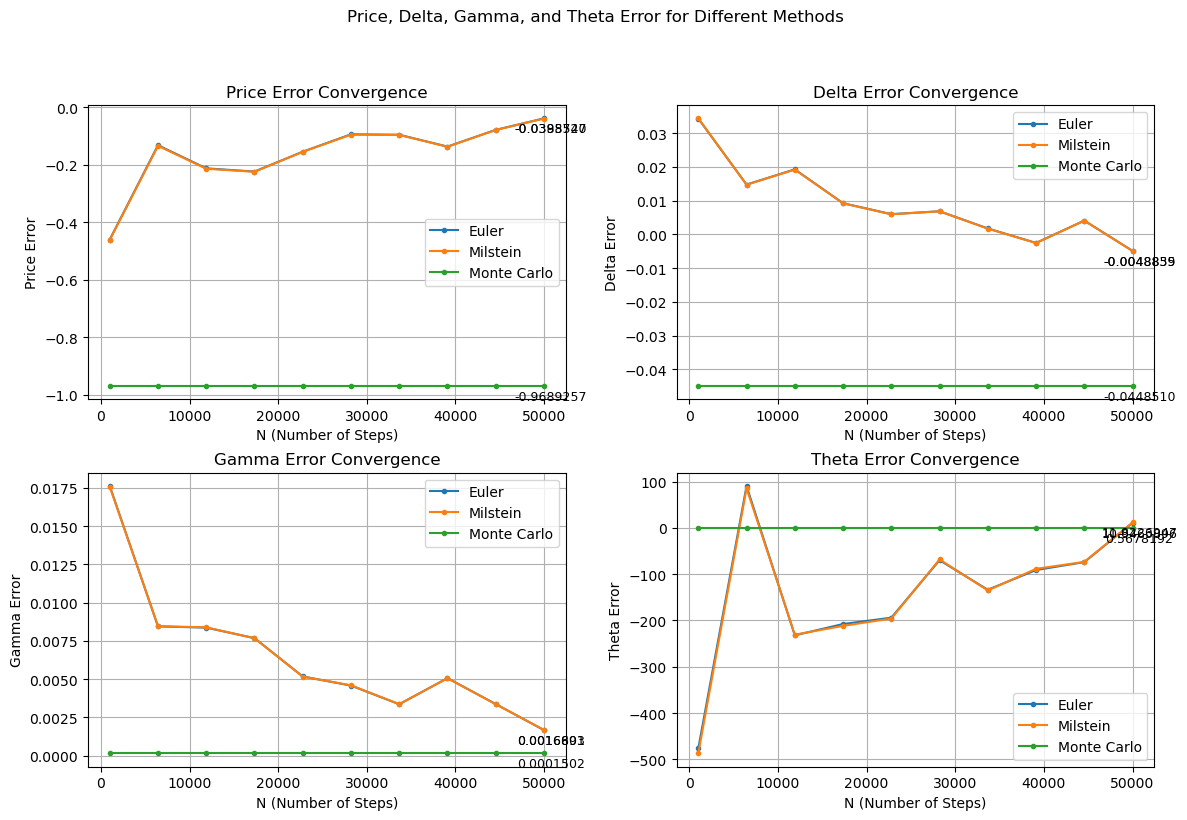

In [12]:
errors_euler = {'price': [], 'delta': [], 'gamma': [], 'theta': []}
errors_milstein = {'price': [], 'delta': [], 'gamma': [], 'theta': []}
errors_monte_carlo = {'price': [], 'delta': [], 'gamma': [], 'theta': []}

analytical_price = analytical_values[0]
analytical_delta = analytical_values[1]
analytical_gamma = analytical_values[2]
analytical_theta = analytical_values[3]

M_values = np.linspace(1000, 50000, 10, dtype = int).tolist()
M = 100000

for M in M_values:
    e_price, e_delta, e_gamma, e_theta = euler(S0, K, T, r, sigma, N, M)
    m_price, m_delta, m_gamma, m_theta = milstein(S0, K, T, r, sigma, N, M)
    mc_price, mc_delta, mc_gamma, mc_theta = monte_carlo_and_greeks(S0, K, T, r, sigma, N, delta_T)

    errors_euler['price'].append(e_price - analytical_price)
    errors_euler['delta'].append(e_delta - analytical_delta)
    errors_euler['gamma'].append(e_gamma - analytical_gamma)
    errors_euler['theta'].append(e_theta - analytical_theta)

    errors_milstein['price'].append(m_price - analytical_price)
    errors_milstein['delta'].append(m_delta - analytical_delta)
    errors_milstein['gamma'].append(m_gamma - analytical_gamma)
    errors_milstein['theta'].append(m_theta - analytical_theta)

    errors_monte_carlo['price'].append(mc_price - analytical_price)
    errors_monte_carlo['delta'].append(mc_delta - analytical_delta)
    errors_monte_carlo['gamma'].append(mc_gamma - analytical_gamma)
    errors_monte_carlo['theta'].append(mc_theta - analytical_theta)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
metrics = ['price', 'delta', 'gamma', 'theta']
titles = ['Price Error', 'Delta Error', 'Gamma Error', 'Theta Error']

def annotate_final_value(ax, x_values, y_values, label):
    final_x = x_values[-1]
    final_y = y_values[-1]
    ax.annotate(f'{final_y:.7f}', (final_x, final_y), textcoords="offset points", xytext=(5, -10), ha='center', fontsize=9)
    ax.plot(x_values, y_values, label=label, marker='.')

for ax, metric, title in zip(axs.flat, metrics, titles):
    annotate_final_value(ax, M_values, errors_euler[metric], 'Euler')
    annotate_final_value(ax, M_values, errors_milstein[metric], 'Milstein')
    annotate_final_value(ax, M_values, errors_monte_carlo[metric], 'Monte Carlo')

    ax.set_xlabel('N (Number of Steps)')
    ax.set_ylabel(title)
    ax.set_title(f'{title} Convergence')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.suptitle('Price, Delta, Gamma, and Theta Error for Different Methods', y=1.02)
plt.subplots_adjust(top=0.9)
plt.show()


### Interpretation of Graphs

**Top-Left: Price Error Convergence**
- **Monte Carlo**: 
  - The error remains constant at about 0.05 across all steps, suggesting a bias that does not change with more steps.
- **Euler and Milstein**:
  - The Milstein method quickly converges to a small negative error and stabilizes as the number of steps increases.
  - The Euler method also shows stabilization.

**Top-Right: Delta Error Convergence**
- **Monte Carlo**: 
  - The error remains close to zero, indicating accurate estimates.
- **Euler and Milstein**:
  - The Milstein method initially has a high error but quickly reduces as steps increase.
  - The Euler method stabilizes at a relatively small error.

**Bottom-Left: Gamma Error Convergence**
- **Monte Carlo**:
  - The error remains close to zero.m
- **Euler and Milstein**:
  - Both methods have larger errors, with Milstein and Euler showing significant initial errors before stabilizing.

**Bottom-Right: Theta Error Convergence**
- **Monte Carlo**:
  - The error is close to zero, suggesting accurate estimates.
- **Euler and Milstein**:
  - Both methods show high initial errors but gradually reduce.
  - Milstein eventually stabilizes with a small negative error.

### General Observations
1. **Stability**:
   - Monte Carlo is consistently stable across all metrics.

2. **Bias**:
   - Milstein and Euler methods both show biases in their estimates of price and Greeks.
   - Monte Carlo retains a fixed bias for the price.

3. **Convergence**:
   - Milstein and Euler both exhibit convergence trends that improve with increasing steps.

# Monte Carlo Approximation of Call Price, Delta, Gamma, and Theta Under Risk Neutral Measure with $log(S_T)$

In [13]:
def monte_carlo_log_and_greeks(S0, K, T, r, sigma, N, epsilon, delta_T):
    np.random.seed(0)
    Z = np.random.standard_normal(N)
    log_ST = np.log(S0) + (r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z
    ST = np.exp(log_ST)
    payoffs = np.maximum(ST - K, 0)
    C0 = np.exp(-r * T) * np.mean(payoffs)

    S_up = S0 + epsilon
    S_down = S0 - epsilon

    log_ST_up = np.log(S_up) + (r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z
    log_ST_down = np.log(S_down) + (r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z

    ST_up = np.exp(log_ST_up)
    ST_down = np.exp(log_ST_down)

    payoffs_up = np.maximum(ST_up - K, 0)
    payoffs_down = np.maximum(ST_down - K, 0)

    C_up = np.exp(-r * T) * np.mean(payoffs_up)
    C_down = np.exp(-r * T) * np.mean(payoffs_down)

    Delta = (C_up - C_down) / (2 * epsilon)
    Gamma = (C_up - 2 * C0 + C_down) / (epsilon ** 2)

    log_ST_T = np.log(S0) + (r - 0.5 * sigma**2) * (T - delta_T) + sigma * np.sqrt(T - delta_T) * Z
    ST_T = np.exp(log_ST_T)

    payoffs_T = np.maximum(ST_T - K, 0)
    C_T = np.exp(-r * (T - delta_T)) * np.mean(payoffs_T)

    Theta = (C_T - C0) / (delta_T )

    return C0, Delta, Gamma, Theta

price, delta, gamma, theta = monte_carlo_log_and_greeks(S0, K, T, r, sigma, N, epsilon, delta_T)

print("Option Price:", price)
print("Delta:", delta)
print("Gamma:", gamma)
print("Theta:", theta)


Option Price: 9.481657895692674
Delta: 0.6020809834319536
Gamma: 0.01620455028161416
Theta: -5.846208300701328


#  Plotting $log(S_t)$ Monte Carlo Outputs with Different Simulation Numbers 

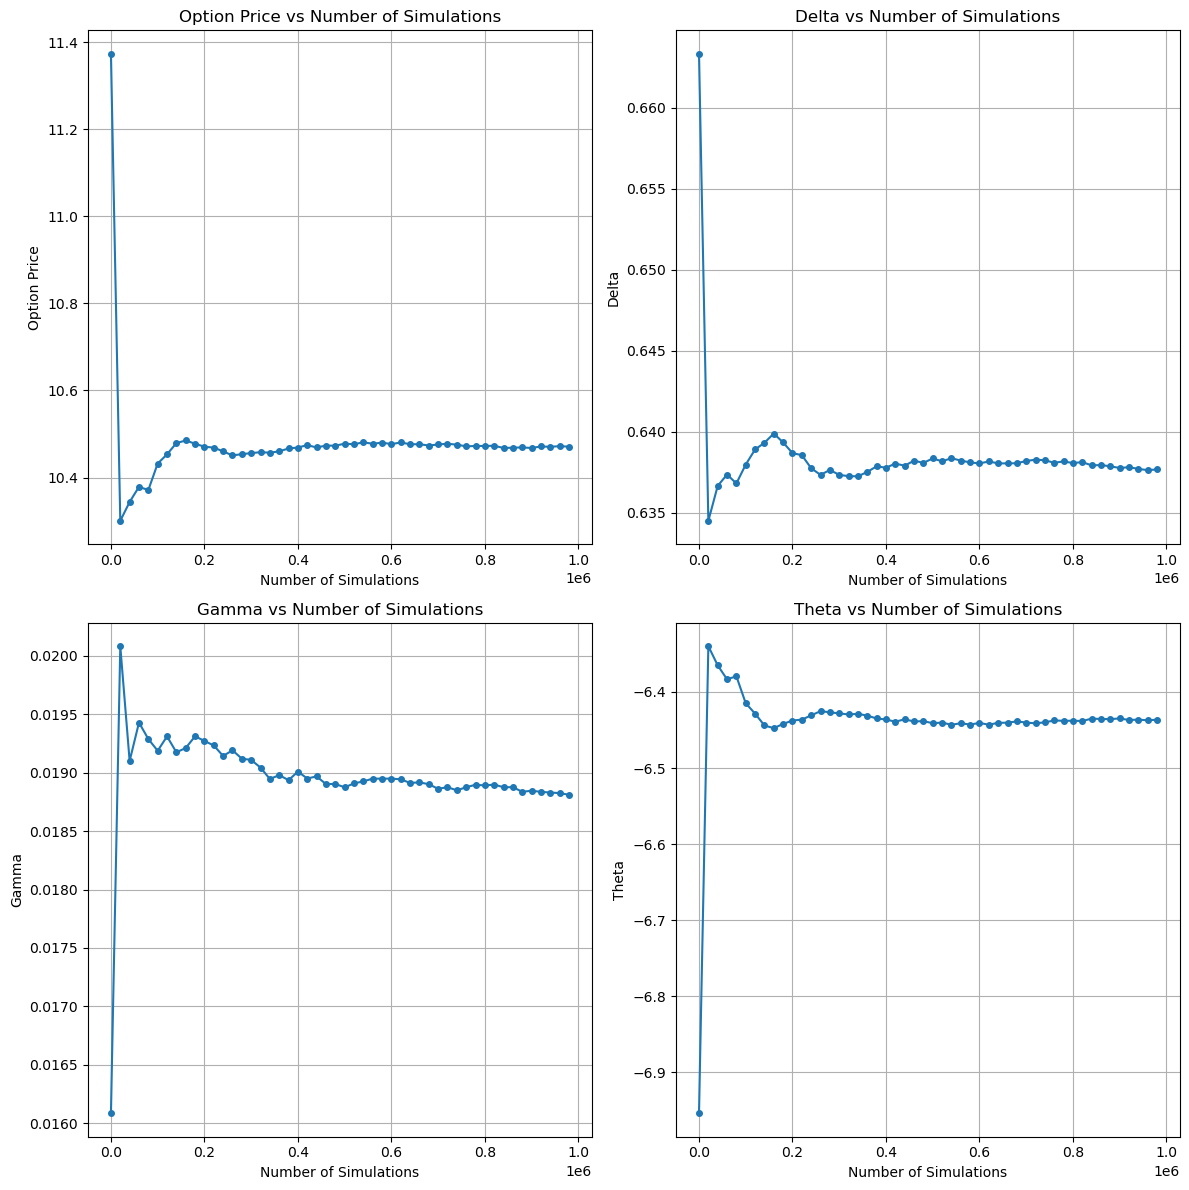

In [14]:
simulation_sizes = np.arange(100, 1000000, 20000).tolist()
results = []
for N in simulation_sizes:
    option_price, Delta, Gamma, Theta = monte_carlo_log_and_greeks(S0, K, T, r, sigma, N, epsilon, delta_T)
    results.append((N, option_price, Delta, Gamma, Theta))
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
metrics = ['Option Price', 'Delta', 'Gamma', 'Theta']
for i, metric in enumerate(metrics):
    row, col = i // 2, i % 2
    values = [result[i+1] for result in results]
    axs[row, col].plot(simulation_sizes, values, 'o-', markersize=4)
    axs[row, col].set_title(f'{metric} vs Number of Simulations')
    axs[row, col].set_xlabel('Number of Simulations')
    axs[row, col].set_ylabel(metric)
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()


# Euler Approximation of Call Price, Delta, Gamma, and Theta Under Risk Neutral Measure with $log(S_T)$

#### Euler Discretization with Log Scheme

To simulate paths of the stock price over a time interval $[0, T]$, we discretize the interval into $N$ steps of size $\Delta t = \frac{T}{N}$. For the Euler scheme in a logarithmic setting, the log of the stock price is approximated at each step $k$ by:

$$
\ln(S_{t+\Delta t}) = \ln(S_t) + \left( r - 0.5 \sigma^2 \right) \Delta t + \sigma \sqrt{\Delta t} Z_t,
$$

where $Z_t$ is a standard normal random variable. The stock price paths are then obtained by exponentiating these logarithmic paths.

#### Price Estimation

We simulate $M$ independent paths of the stock price using the logarithmic Euler scheme. The payoff of a European call option at maturity is $max(S_T - K, 0) $, where $K$ is the strike price. The estimated option price is the average of discounted payoffs:

$$
C = e^{-rT} \frac{1}{M} \sum_{i=1}^{M} max(S_T^{(i)} - K, 0).
$$

#### Greeks Calculation

**Delta and Gamma**: These are estimated using finite difference methods. We simulate additional paths for $S_0 + \epsilon$ and $S_0 - \epsilon$ to calculate:

$$
\Delta \approx \frac{C(S_0 + \epsilon) - C(S_0 - \epsilon)}{2 \epsilon}, 
$$

$$
\Gamma \approx \frac{C(S_0 + \epsilon) - 2C(S_0) + C(S_0 - \epsilon)}{\epsilon^2}.
$$

**Theta**: We approximate Theta by simulating the option price with a slightly shorter maturity, $T - \delta$, and calculate:

$$
\Theta \approx \frac{C(T) - C(T - \delta)}{\delta \times 365},
$$

where $\delta$ represents the difference between the original maturity and the shorter maturity in days.


In [15]:
def euler_log(S0, K, T, r, sigma, N, M, epsilon):
    np.random.seed(0)
    dt = T / N
    discount_factor = np.exp(-r * T)
    
    log_paths = np.zeros((M, 3))
    log_paths[:, 0] = np.log(S0)
    log_paths[:, 1] = np.log(S0 + epsilon)
    log_paths[:, 2] = np.log(S0 - epsilon)

    for _ in range(N):
        Z = np.random.standard_normal((M, 3))
        log_paths += (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z

    paths = np.exp(log_paths)

    payoffs = np.maximum(paths - K, 0)
    C = np.mean(payoffs[:, 0]) * discount_factor
    C_up = np.mean(payoffs[:, 1]) * discount_factor
    C_down = np.mean(payoffs[:, 2]) * discount_factor

    delta = (C_up - C_down) / (2 * epsilon)
    gamma = (C_up - 2 * C + C_down) / (epsilon**2)
    
    delta_t = dt
    T_short = T - delta_t
    log_paths_short = np.full(M, np.log(S0))

    for _ in range(int(N * (T_short / T))):
        Z = np.random.standard_normal(M)
        log_paths_short += (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z

    paths_short = np.exp(log_paths_short)
    payoffs_short = np.maximum(paths_short - K, 0)
    C_short = np.mean(payoffs_short) * np.exp(-r * T_short)
    
    theta = (C_short - C) / (delta_t)

    return C, delta, gamma, theta

N = 252
M=1000000
price, delta, gamma, theta = euler_log(S0, K, T, r, sigma, N, M, 30)
print("Option Price:", price)
print("Delta:", delta)
print("Gamma:", gamma)
print("Theta:", theta)


Option Price: 10.448036542833304
Delta: 0.5840042735317726
Gamma: 0.016690494237500412
Theta: -11.551821002730414


## Plotting Euler Method Outputs with Different Time Steps: $log(S_t)$

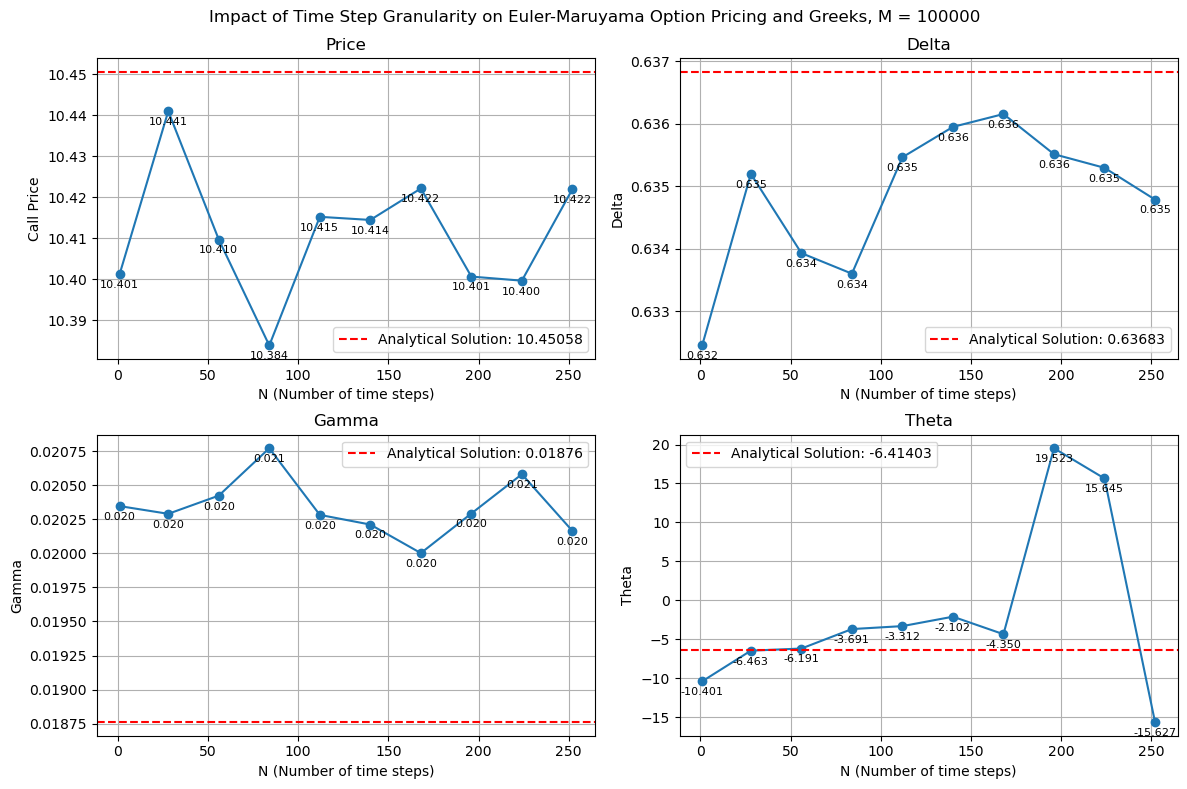

In [16]:
N_values = np.linspace(1, 252, 10, dtype= int).tolist()
M = 100000
results = []
for N in N_values:
    results.append(euler_log(S0, K, T, r, sigma, N, M, 10))
prices, deltas, gammas, thetas = zip(*results)

plt.figure(figsize=(12, 8))
titles = ['Price', 'Delta', 'Gamma', 'Theta']
data = [prices, deltas, gammas, thetas]
y_labels = ['Call Price', 'Delta', 'Gamma', 'Theta']

for i, (title, dataset, y_label, h_line) in enumerate(zip(titles, data, y_labels, analytical_values), start=1 ):
    ax = plt.subplot(2, 2, i)
    ax.plot(N_values, dataset, marker='o')
    ax.set_title(title)
    ax.set_xlabel('N (Number of time steps)')
    ax.set_ylabel(y_label)
    ax.axhline(y=h_line, color='r', linestyle='--', label=f'Analytical Solution: {h_line:.5f}')
    ax.grid(True)
    ax.legend()
    for x, y in zip(N_values, dataset):
        ax.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,-10), ha='center', fontsize = 8)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle(f"Impact of Time Step Granularity on Euler-Maruyama Option Pricing and Greeks, M = {M}")

plt.show()


## Plotting Euler Method Outputs with Different Simulation Numbers: $log(S_t)$

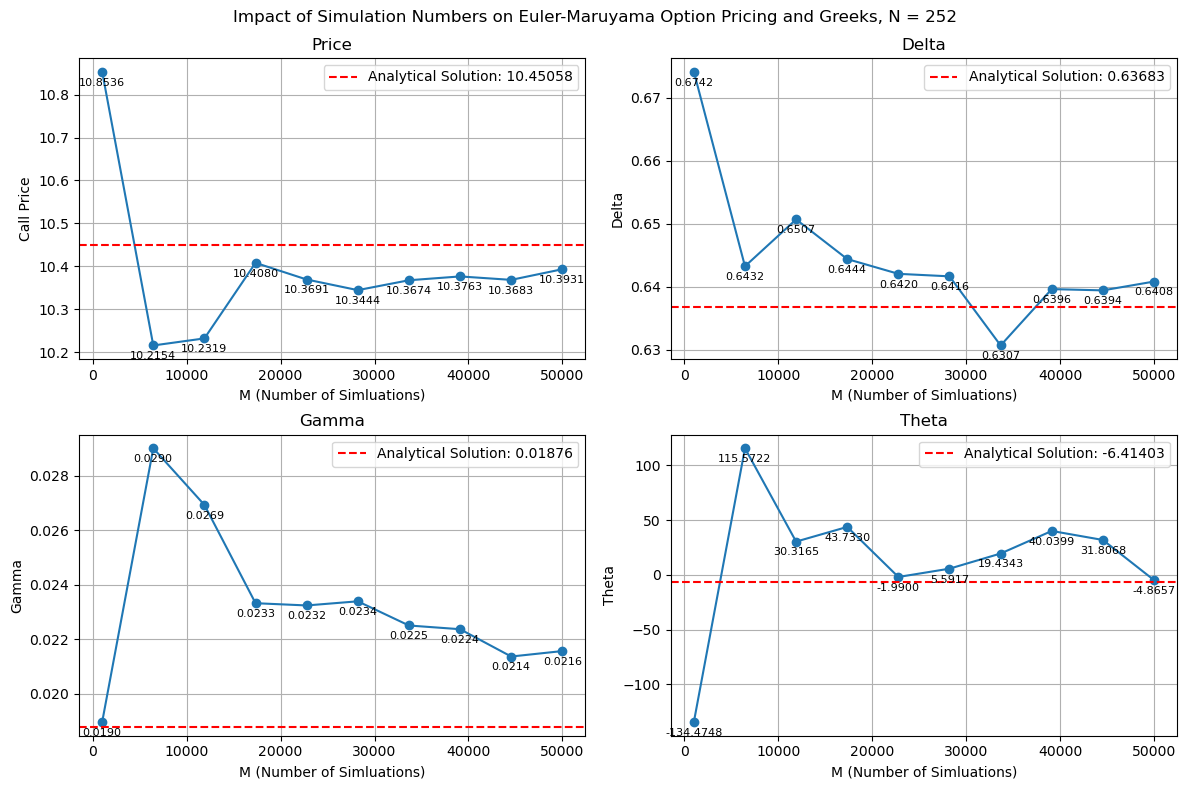

In [17]:
results = []
for M in M_values:
    results.append(euler_log(S0, K, T, r, sigma, N, M, 10))
prices, deltas, gammas, thetas = zip(*results)

plt.figure(figsize=(12, 8))
titles = ['Price', 'Delta', 'Gamma', 'Theta']
data = [prices, deltas, gammas, thetas]
y_labels = ['Call Price', 'Delta', 'Gamma', 'Theta']

for i, (title, dataset, y_label, h_line) in enumerate(zip(titles, data, y_labels, analytical_values), start=1 ):
    ax = plt.subplot(2, 2, i)
    ax.plot(M_values, dataset, marker='o')
    ax.set_title(title)
    ax.set_xlabel('M (Number of Simluations)')
    ax.set_ylabel(y_label)
    ax.axhline(y=h_line, color='r', linestyle='--', label=f'Analytical Solution: {h_line:.5f}')
    ax.grid(True)
    ax.legend()
    for x, y in zip(M_values, dataset):
        ax.annotate(f'{y:.4f}', (x, y), textcoords="offset points", xytext=(0,-10), ha='center', fontsize = 8)


plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle(f"Impact of Simulation Numbers on Euler-Maruyama Option Pricing and Greeks, N = {N}")

plt.show()


#  Milstein Approximation of Call Price, Delta, Gamma, and Theta Under Risk Neutral Measure with $log(S_T)$

In [18]:
def milstein_log(S0, K, T, r, sigma, N, M):
    np.random.seed(0)
    dt = T / N
    discount_factor = np.exp(-r * T)
    epsilon = 5

    log_paths = np.zeros((M, 3))  # ln(S), ln(S_up), ln(S_down)
    log_paths[:, 0] = np.log(S0)
    log_paths[:, 1] = np.log(S0 + epsilon)
    log_paths[:, 2] = np.log(S0 - epsilon)

    for _ in range(N):
        dW = np.random.normal(0, np.sqrt(dt), (M, 3))
        log_paths += (r - 0.5 * sigma**2) * dt + sigma * dW + 0.5 * sigma**2 * (dW**2 - dt)

    paths = np.exp(log_paths)

    payoffs = np.maximum(paths - K, 0)
    price = np.mean(payoffs, axis=0) * discount_factor

    delta = (price[1] - price[2]) / (2 * epsilon)
    gamma = (price[1] - 2 * price[0] + price[2]) / (epsilon**2)

    log_paths_theta = np.full(M, np.log(S0))
    for _ in range(N-1):
        dW = np.random.normal(0, np.sqrt(dt), M)
        log_paths_theta += (r - 0.5 * sigma**2) * dt + sigma * dW + 0.5 * sigma**2 * (dW**2 - dt)
    
    paths_theta = np.exp(log_paths_theta)
    payoffs_theta = np.maximum(paths_theta - K, 0)
    price_theta = np.mean(payoffs_theta) * np.exp(-r * (T - dt))

    theta = (price_theta-price[0]) / (dt)

    return price[0], delta, gamma, theta

price, delta, gamma, theta = milstein_log(S0, K, T, r, sigma, N, M)
print("Option Price:", price)
print("Delta:", delta)
print("Gamma:", gamma)
print("Theta:", theta)

Option Price: 10.393014472386342
Delta: 0.6566412594432987
Gamma: 0.02972181573873229
Theta: -4.578811273409379


# Plotting Milstein Method Outputs with Different Time Steps: $log(S_t)$

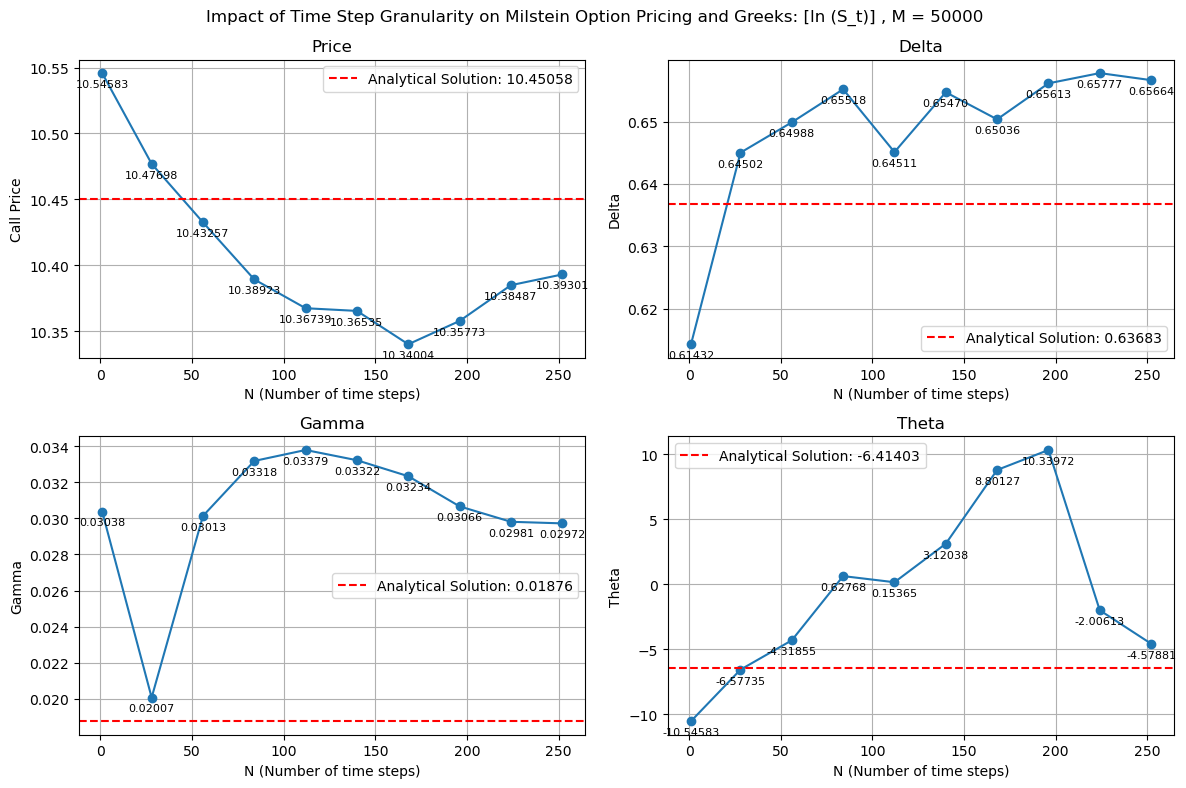

In [19]:
results = []
for N in N_values:
    results.append(milstein_log(S0, K, T, r, sigma, N, M))
prices, deltas, gammas, thetas = zip(*results)

plt.figure(figsize=(12, 8))
titles = ['Price', 'Delta', 'Gamma', 'Theta']
data = [prices, deltas, gammas, thetas]
y_labels = ['Call Price', 'Delta', 'Gamma', 'Theta']

for i, (title, dataset, y_label, h_line) in enumerate(zip(titles, data, y_labels, analytical_values), start=1):
    ax = plt.subplot(2, 2, i)
    ax.plot(N_values, dataset, marker='o')
    ax.set_title(title)
    ax.set_xlabel('N (Number of time steps)')
    ax.set_ylabel(y_label)
    ax.axhline(y=h_line, color='r', linestyle='--', label=f'Analytical Solution: {h_line:.5f}')
    ax.grid(True)
    ax.legend()
    # Annotating data points
    for x, y in zip(N_values, dataset):
        ax.annotate(f'{y:.5f}', (x, y), textcoords="offset points", xytext=(0,-10), ha='center', fontsize = 8)
plt.suptitle(f"Impact of Time Step Granularity on Milstein Option Pricing and Greeks: [ln (S_t)] , M = {M}")

plt.tight_layout()
plt.show()


## Plotting Milstein Method Outputs with Different Simulation Numbers: $log(S_t)$

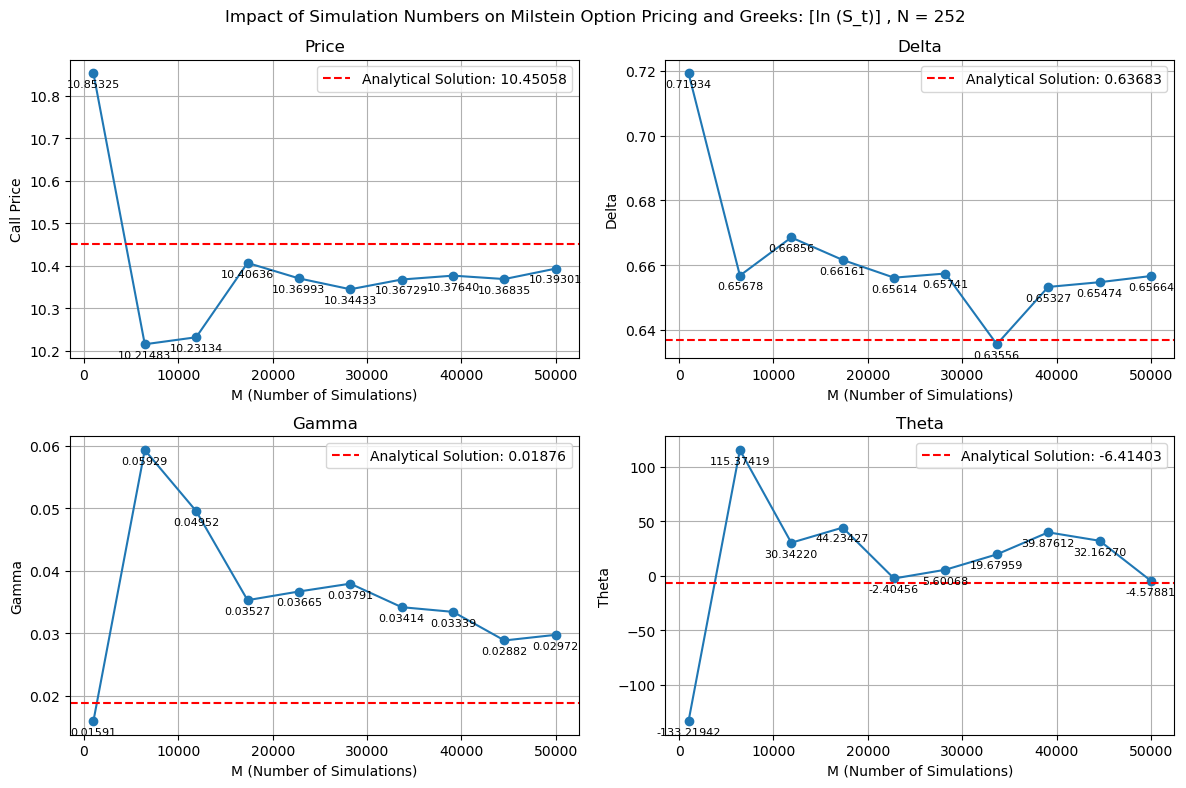

In [20]:
results = []
for M in M_values:
    results.append(milstein_log(S0, K, T, r, sigma, N, M))
prices, deltas, gammas, thetas = zip(*results)

plt.figure(figsize=(12, 8))
titles = ['Price', 'Delta', 'Gamma', 'Theta']
data = [prices, deltas, gammas, thetas]
y_labels = ['Call Price', 'Delta', 'Gamma', 'Theta']

for i, (title, dataset, y_label, h_line) in enumerate(zip(titles, data, y_labels, analytical_values), start=1):
    ax = plt.subplot(2, 2, i)
    ax.plot(M_values, dataset, marker='o')
    ax.set_title(title)
    ax.set_xlabel('M (Number of Simulations)')
    ax.set_ylabel(y_label)
    ax.axhline(y=h_line, color='r', linestyle='--', label=f'Analytical Solution: {h_line:.5f}')
    ax.grid(True)
    ax.legend()
    # Annotating data points
    for x, y in zip(M_values, dataset):
        ax.annotate(f'{y:.5f}', (x, y), textcoords="offset points", xytext=(0,-10), ha='center', fontsize = 8)
plt.suptitle(f"Impact of Simulation Numbers on Milstein Option Pricing and Greeks: [ln (S_t)] , N = {N}")
plt.tight_layout()
plt.show()


# Comparing Performance

100%|███████████████████████████████████████████| 10/10 [00:12<00:00,  1.27s/it]


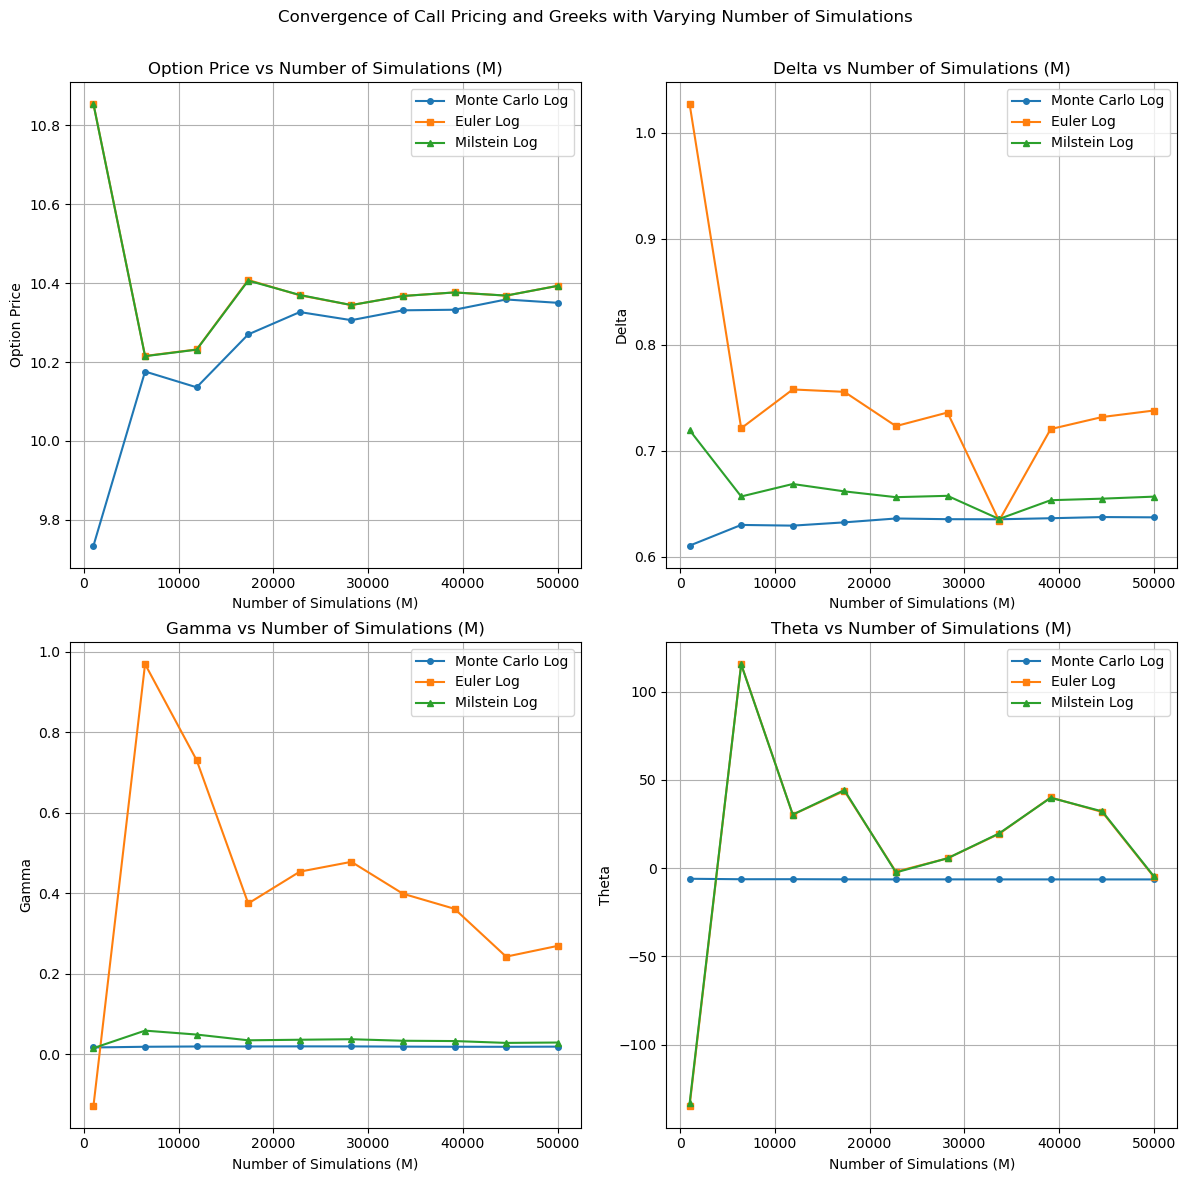

In [21]:
results_mc = []
results_euler = []
results_milstein = []

for M in tqdm(M_values):
    # Monte Carlo Log
    price_mc, delta_mc, gamma_mc, theta_mc = monte_carlo_log_and_greeks(S0, K, T, r, sigma, M, epsilon, delta_T)
    results_mc.append((M, price_mc, delta_mc, gamma_mc, theta_mc))

    # Euler Log
    price_euler, delta_euler, gamma_euler, theta_euler = euler_log(S0, K, T, r, sigma, N, M, epsilon)
    results_euler.append((M, price_euler, delta_euler, gamma_euler, theta_euler))

    # Milstein Log
    price_milstein, delta_milstein, gamma_milstein, theta_milstein = milstein_log(S0, K, T, r, sigma, N, M)
    results_milstein.append((M, price_milstein, delta_milstein, gamma_milstein, theta_milstein))

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
metrics = ['Option Price', 'Delta', 'Gamma', 'Theta']
for i, metric in enumerate(metrics):
    row, col = i // 2, i % 2
    values_mc = [result[i + 1] for result in results_mc]
    values_euler = [result[i + 1] for result in results_euler]
    values_milstein = [result[i + 1] for result in results_milstein]

    axs[row, col].plot(M_values, values_mc, 'o-', label='Monte Carlo Log', markersize=4)
    axs[row, col].plot(M_values, values_euler, 's-', label='Euler Log', markersize=4)
    axs[row, col].plot(M_values, values_milstein, '^-', label='Milstein Log', markersize=4)

    axs[row, col].set_title(f'{metric} vs Number of Simulations (M)')
    axs[row, col].set_xlabel('Number of Simulations (M)')
    axs[row, col].set_ylabel(metric)
    axs[row, col].grid(True)
    axs[row, col].legend()

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle("Convergence of Call Pricing and Greeks with Varying Number of Simulations", y=0.98)
plt.show()

### Interpretation of Graphs

**Top-Left: Option Price vs. Number of Simulations (M)**
- **Monte Carlo Log**:
  - The option price is lower initially but converges upward, stabilizing around $ M = 10,000 $.
- **Euler Log**:
  - The price stabilizes quickly and remains relatively constant across all values of $ M $.
- **Milstein Log**:
  - The price remains stable and shows similar trends to the Euler Log method.

**Top-Right: Delta vs. Number of Simulations (M)**
- **Monte Carlo Log**:
  - The Delta value is stable across all values of $ M $.
- **Euler Log**:
  - The Delta value starts high but quickly decreases and fluctuates at higher $ M $ values.
- **Milstein Log**:
  - The Delta value gradually increases before stabilizing.

**Bottom-Left: Gamma vs. Number of Simulations (M)**
- **Monte Carlo Log**:
  - The Gamma value remains consistently low across all simulation sizes.
- **Euler Log**:
  - The Gamma value is initially high, decreases, and remains fairly stable beyond $ M = 20,000 $.
- **Milstein Log**:
  - Gamma values remain low and stable across different $ M $ values.

**Bottom-Right: Theta vs. Number of Simulations (M)**
- **Monte Carlo Log**:
  - Theta remains consistently low and stable across all values of $M $.
- **Euler Log**:
  - Theta starts high, drops sharply, and stabilizes at higher simulation sizes.
- **Milstein Log**:
  - Theta shows significant fluctuations initially but stabilizes at higher $M $.

### General Observations
1. **Stability**:
   - **Monte Carlo Log** shows consistent stability for all metrics.
   - **Euler Log** and **Milstein Log** methods fluctuate initially but stabilize with increasing $ M $.

2. **Convergence**:
   - All three methods demonstrate improvements with increased simulation sizes, with the Monte Carlo Log method providing consistent results for all metrics.